In [1]:
from google.colab import drive
drive.mount('/content/drive')
drive_folder = '/content/drive/MyDrive'
# Ajust this line to be the assignment1 folder in your google drive
notebook_folder = drive_folder + '/cs696'
%cd {notebook_folder}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/cs696


In [2]:
notebook_folder += '/PretrainingBert'
%cd {notebook_folder}

/content/drive/MyDrive/cs696/PretrainingBert


In [3]:
# !pip install transformers datasets
# !pip install magic-timer
# !pip install accelerate -U
# # !pip install transformers[torch]
# !pip install wandb
# !pip install pynvml

In [4]:
import json
from pathlib import Path
from typing import Iterator
import time
import torch.nn as nn
import datasets
import matplotlib.pyplot as plt
import pandas as pd
import pynvml
import torch
from tokenizers import BertWordPieceTokenizer, Regex, normalizers
from tqdm import tqdm
from transformers import (
    BertTokenizerFast,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)

from library.transformers.src.transformers.models.bert.modeling_bert import BertForMaskedLM
from library.transformers.src.transformers.models.bert.configuration_bert import BertConfig
import os
from os import path

In [5]:
os.environ["WANDB_DISABLED"] = "true"

# Print hardware information
pynvml.nvmlInit()
handle = pynvml.nvmlDeviceGetHandleByIndex(0)
gpu_name = pynvml.nvmlDeviceGetName(handle)
gpu_mem = pynvml.nvmlDeviceGetMemoryInfo(handle).total / (1024**3)
print(f"GPU: {gpu_name}, {gpu_mem} GB")
print(f"{torch.cuda.is_available() = }")

GPU: Tesla T4, 15.0 GB
torch.cuda.is_available() = True


In [6]:
LIMIT_DATASET = 10 * 4  # keep small for development, set to None for full dataset

RANDOM_SEED = 42
NUM_TOKENIZER_TRAINING_ITEMS = 1_000_000  # I made this up, but it seems reasonable
VOCAB_SIZE = 32_768  # from Cramming
DEVICE_BATCH_SIZE = 36  # adjust to get near 100% gpu memory use
MODEL_MAX_SEQ_LEN = 96  # from Cramming
HIDDEN_SIZE = 128

gradient_accumulation_steps = 2048 // DEVICE_BATCH_SIZE  # roughly based on Cramming
batch_size = DEVICE_BATCH_SIZE * gradient_accumulation_steps
print(f"{DEVICE_BATCH_SIZE = }")
print(f"{gradient_accumulation_steps = }")
print(f"{batch_size = }")

RUN_DIR = Path("data") / f"run_{time.strftime('%Y%m%d-%H%M%S')}"
CHECKPOINT_DIR = RUN_DIR / "training_checkpoints"
MODEL_DIR = RUN_DIR / "model"
TOKENIZER_PATH = RUN_DIR / "tokenizer.json"
TRAINER_HISTORY_PATH = RUN_DIR / "trainer_history.json"

RUN_DIR.mkdir(exist_ok=True, parents=True)

DEVICE_BATCH_SIZE = 36
gradient_accumulation_steps = 56
batch_size = 2016


In [7]:
from magic_timer import MagicTimer
with MagicTimer() as timer:
    dataset = datasets.load_dataset(
        "sradc/chunked-shuffled-wikipedia20220301en-bookcorpusopen",
        split=f"train[:{LIMIT_DATASET}]" if LIMIT_DATASET else "train",
        revision="0e6fada2dd43136e4a3f637da41de2e596aee674",
    )
print(f"Loaded dataset in {timer}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/53 [00:00<?, ?it/s]

Loaded dataset in 4.6 seconds


In [8]:
tokenizer = BertWordPieceTokenizer()
tokenizer._tokenizer.normalizer = normalizers.Sequence(
    [
        normalizers.Replace(Regex("(``|'')"), '"'),
        normalizers.NFD(),
        normalizers.Lowercase(),
        normalizers.StripAccents(),
        normalizers.Replace(Regex(" {2,}"), " "),
        normalizers.Replace(Regex(r"[^\x00-\x7F]+"), ""),
    ]
)

In [9]:
def tokenizer_training_data() -> Iterator[str]:
    for i in tqdm(
        range(min(NUM_TOKENIZER_TRAINING_ITEMS, len(dataset))),
        desc="Feeding samples to tokenizer",
    ):
        yield dataset[i]["text"]

In [10]:
with MagicTimer() as timer:
    tokenizer.train_from_iterator(
        tokenizer_training_data(),
        vocab_size=VOCAB_SIZE,
        min_frequency=2,
    )
print(f"Tokenizer trained in {timer}.")
tokenizer.save(str(TOKENIZER_PATH))

Feeding samples to tokenizer: 100%|██████████| 8064/8064 [00:04<00:00, 1667.41it/s]


Tokenizer trained in 10.0 seconds.


In [30]:
%load_ext autoreload
%autoreload 2
from library.transformers.src.transformers.models.bert.modeling_bert import BertForMaskedLM
from library.transformers.src.transformers.models.bert.configuration_bert import BertConfig
model_config = BertConfig(
    vocab_size=VOCAB_SIZE,
    hidden_size=HIDDEN_SIZE,
    max_sequence_length = MODEL_MAX_SEQ_LEN,
    # max_sequence_length = 96,
    intermediate_size=4*HIDDEN_SIZE,
    max_position_embeddings=HIDDEN_SIZE,
    # mlp_layers = [1],
)
model = BertForMaskedLM(model_config, max_sequence_length=96, mlp_layers=[1] )
tokenizer = BertTokenizerFast(tokenizer_file=str(TOKENIZER_PATH))

In [31]:
class TokenizedDataset(torch.utils.data.Dataset):
    "This wraps the dataset and tokenizes it, ready for the model"

    def __init__(self, dataset, tokenizer):
        self.dataset = dataset
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, i):
        return self.tokenizer.encode(
            self.dataset[i]["text"],
            return_tensors="pt",
            truncation=True,
            max_length=MODEL_MAX_SEQ_LEN,
            padding="max_length",
            return_special_tokens_mask=True,
        )[0, ...]

tokenized_dataset = TokenizedDataset(dataset, tokenizer)

In [26]:
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=True,
    mlm_probability=0.15,
    return_tensors="pt",
)

In [32]:
training_args = TrainingArguments(
    # Optimizer values are from Cramming
    learning_rate=1e-3,
    warmup_ratio=0.5,
    adam_beta1=0.9,
    adam_beta2=0.98,
    adam_epsilon=1e-9,
    weight_decay=0.01,
    max_grad_norm=0.5,
    num_train_epochs=40,
    per_device_train_batch_size=DEVICE_BATCH_SIZE,
    gradient_accumulation_steps=gradient_accumulation_steps,
    dataloader_num_workers=4,
    save_steps=60,
    save_total_limit=2,
    logging_steps=1,
    output_dir=CHECKPOINT_DIR,
    optim="adamw_torch",
    report_to=None,
)
Trainer._get_train_sampler = lambda _: None  # prevent shuffling the dataset again
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_dataset,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
with MagicTimer() as timer:
    trainer.train()
print(f"Trained model in {timer}.")
# trainer.save_model(str(MODEL_DIR))
TRAINER_HISTORY_PATH.write_text(json.dumps(trainer.state.log_history))


Step,Training Loss


In [22]:
torch.save(model.state_dict(), str(MODEL_DIR))
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
bert.embeddings.word_embeddings.weight 	 torch.Size([32768, 96])
bert.embeddings.position_embeddings.weight 	 torch.Size([96, 96])
bert.embeddings.token_type_embeddings.weight 	 torch.Size([2, 96])
bert.embeddings.LayerNorm.weight 	 torch.Size([96])
bert.embeddings.LayerNorm.bias 	 torch.Size([96])
bert.encoder.layer.0.attention.self.query.weight 	 torch.Size([96, 96])
bert.encoder.layer.0.attention.self.query.bias 	 torch.Size([96])
bert.encoder.layer.0.attention.self.key.weight 	 torch.Size([96, 96])
bert.encoder.layer.0.attention.self.key.bias 	 torch.Size([96])
bert.encoder.layer.0.attention.self.value.weight 	 torch.Size([96, 96])
bert.encoder.layer.0.attention.self.value.bias 	 torch.Size([96])
bert.encoder.layer.0.attention.output.dense.weight 	 torch.Size([96, 96])
bert.encoder.layer.0.attention.output.dense.bias 	 torch.Size([96])
bert.encoder.layer.0.attention.output.LayerNorm.weight 	 torch.Size([96])
bert.encoder.layer.0.attention.output.LayerNorm.bias 	

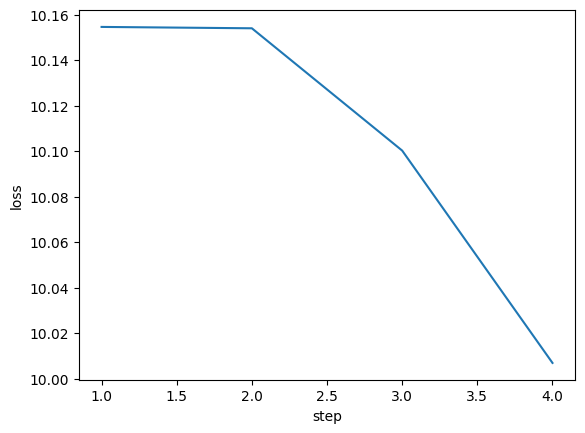

In [23]:
trainer_history = pd.DataFrame(trainer.state.log_history[:-1]).set_index("step")
trainer_history.loss.plot(label="loss")
plt.ylabel("loss")
plt.savefig(RUN_DIR / "loss.png")

In [ ]:
def visualizMLPWeights(model):
  """
  visualize the paramters of this layer
  """
  # weight_matrix = self.net.weight.detach().cpu()
  weight_matrix = model.state_dict()["bert.encoder.layer.0.mlp.dense.weight"].detach().cpu()
  plt.imshow(weight_matrix, cmap='hot', interpolation='nearest')
  plt.colorbar()
  plt.savefig(path.join(MODEL_DIR, "weights.png"))
  plt.clf()

In [ ]:
visualizMLPWeights(model)